# plotting correlation between heterogeneous reconstruction and MD trajectory
This notebook computes the correlation between frames of the MD trajectory and volumes reconstructed by cryoDRGN / cryoSPARC

In [1]:
# imports
import os
import numpy as np
import gemmi
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed
import warnings
import matplotlib.pyplot as plt

from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter

In [2]:
# functions
def filter_gemmi_model(model_gemmi, remove_sidechains=False):
    # remove ligand residues and all sidechain atoms
    list_of_residue_names = [
        "F2A", "H2A", "NLM", "NM5", "NM7", "NME"
    ]
    new_model_gemmi = gemmi.Model(model_gemmi.name)
    for chn in model_gemmi:
        new_chain_gemmi = gemmi.Chain(chn.name)
        for res in chn:
            if res.name not in list_of_residue_names:
                new_res_gemmi = gemmi.Residue()
                new_res_gemmi.name = res.name
                new_res_gemmi.seqid.num = res.seqid.num
                
                if remove_sidechains:
                    for atm in res:
                        if atm.name == "CA":
                            new_atm_gemmi = gemmi.Atom()
                            new_atm_gemmi.name = atm.name
                            new_atm_gemmi.pos = atm.pos
                            new_atm_gemmi.element = gemmi.Element(atm.element.name)
                            new_res_gemmi.add_atom(new_atm_gemmi)

                else:
                    for atm in res:
                        new_atm_gemmi = gemmi.Atom()
                        new_atm_gemmi.name = atm.name
                        new_atm_gemmi.pos = atm.pos
                        new_atm_gemmi.element = gemmi.Element(atm.element.name)
                        new_res_gemmi.add_atom(new_atm_gemmi)                  

                new_chain_gemmi.add_residue(new_res_gemmi)
        new_model_gemmi.add_chain(new_chain_gemmi)
    return new_model_gemmi

# functions
def compute_correlation(modelmap, targetmap, mask, i, j):
    """Compute the correlation between two maps"""
    
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
    # apply mask to both maps
    modelmap_masked = modelmap * mask
    targetmap_masked = targetmap * mask
    # compute the mean of the two maps
    mean_modelmap = np.mean(modelmap_masked)
    mean_targetmap = np.mean(targetmap_masked)
    # compute the standard deviation of the two maps
    std_modelmap = np.std(modelmap_masked)
    std_targetmap = np.std(targetmap_masked)
    # compute the correlation
    correlation = np.mean((modelmap_masked - mean_modelmap) * (targetmap_masked - mean_targetmap)) / (std_modelmap * std_targetmap)
    return correlation, i, j


def compute_correlation(modelmap, targetmap, mask, i, j):
    """Compute the correlation between two maps"""
    
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
    # apply mask to both maps
    modelmap_masked = modelmap * mask
    targetmap_masked = targetmap * mask
    # compute the mean of the two maps
    mean_modelmap = np.mean(modelmap_masked)
    mean_targetmap = np.mean(targetmap_masked)
    # compute the standard deviation of the two maps
    std_modelmap = np.std(modelmap_masked)
    std_targetmap = np.std(targetmap_masked)
    # compute the correlation
    correlation = np.mean((modelmap_masked - mean_modelmap) * (targetmap_masked - mean_targetmap)) / (std_modelmap * std_targetmap)
    return correlation, i, j




## create an ensemble structure to fit to the sampled volumes

In [3]:
# create an ensemble structure
project_dir = "/home/mjoosten1/projects/roodmus/data/c3c3b"
pdb_dir = os.path.join(project_dir, "pdb")
output_dir = os.path.join(project_dir, "cryosparc_P51_J696_series_000", "aligned_ensemble")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith(".pdb")]
pdb_files.sort()
N = 50
# sample N files from the total number of files, evenly spaced
pdb_files = pdb_files[::len(pdb_files)//N]

ensemble_gemmi = gemmi.Structure()
ensemble_CA_gemmi = gemmi.Structure()
for filename in pdb_files:
    pdb_path = os.path.join(pdb_dir, filename)
    frame_gemmi = gemmi.read_structure(pdb_path)
    frame_gemmi_filtered = filter_gemmi_model(frame_gemmi[0], remove_sidechains=False)
    ensemble_gemmi.add_model(frame_gemmi_filtered)
    frame_gemmi_CA = filter_gemmi_model(frame_gemmi[0], remove_sidechains=True)
    ensemble_CA_gemmi.add_model(frame_gemmi_CA)

# write the ensemble to a pdb file
ensemble_gemmi.write_pdb(os.path.join(output_dir, "ensemble.pdb"))
ensemble_CA_gemmi.write_pdb(os.path.join(output_dir, "ensemble_CA.pdb"))

# computing correlation matrix

In [4]:
# inputs and parameters
n_frames = 50
resolution = 3
n_jobs = 12

project_dir = "/home/mjoosten1/projects/roodmus/data/c3c3b"

# vseries_dir = "../data/c3c3b/cryosparc_P51_J689_series_000"
# pdb_dir = "../data/c3c3b/pdb"
# ensemble_filename = "../data/c3c3b/cryosparc_P51_J689_series_000/ensemble_fit_to_vseries.pdb"
# mask_filename = "../data/c3c3b/cryosparc_P51_J689_series_000/ensemble_mask.mrc"
# figures_dir = "../data/c3c3b/figures/"
# latent_coordinates = np.linspace(-0.56, 0.70933336, 41)
# inverted_maps = False

# vseries_dir = "../data/c3c3b/cryosparc_P51_J689_series_001"
# pdb_dir = "../data/c3c3b/pdb"
# ensemble_filename = "../data/c3c3b/cryosparc_P51_J689_series_000/ensemble_fit_to_vseries.pdb"
# mask_filename = "../data/c3c3b/cryosparc_P51_J689_series_000/ensemble_mask.mrc"
# figures_dir = "../data/c3c3b/figures/"
# latent_coordinates = np.linspace(-0.65600002, 0.86933339, 41)
# inverted_maps = False

vseries_dir = os.path.join(project_dir, "cryosparc_P51_J696_series_000")
pdb_dir = os.path.join(project_dir, "pdb")
ensemble_filename = os.path.join(project_dir, "cryosparc_P51_J696_series_000", "aligned_ensemble", "ensemble_aligned.pdb")
mask_filename = os.path.join(project_dir, "cryosparc_P51_J696_series_000", "aligned_ensemble", "ensemble_map.mrc")
figures_dir = os.path.join(project_dir, "figures")
latent_coordinates = np.arange(0, 41)

frames = [r for r in os.listdir(pdb_dir) if r.endswith(".pdb")]
frames.sort()
frames = frames[::int(len(frames)/n_frames)]

volumes = [r for r in os.listdir(vseries_dir) if r.endswith(".mrc") and not r.endswith("inverted.mrc") and "mask" not in r]
volumes.sort()

In [5]:
# step 1: load each frame and compute the modelmap
vseries_vol0 = gemmi.read_ccp4_map(os.path.join(vseries_dir, volumes[0]))
unitcell = vseries_vol0.grid.unit_cell
size = vseries_vol0.grid.shape
vsize = vseries_vol0.grid.spacing[0]

# create list of frames
frames_fit = []
ensemble_fit_gemmi = gemmi.read_structure(ensemble_filename)
for mdl in ensemble_fit_gemmi:
    tmp_struc = gemmi.Structure()
    tmp_struc.add_model(mdl)
    frames_fit.append(tmp_struc)

modelmaps = []
for frame_gemmi in tqdm(frames_fit):
    map_from_model_unfiltered = convert_pdb_to_map(
        input_pdb=frame_gemmi,
        unitcell=unitcell,
        size=size,
        return_grid=False,
    )
    map_from_model_zyx = low_pass_filter(
        map_from_model_unfiltered, resolution, vsize
    )
    map_from_model = np.rot90(
        np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
    )
    modelmaps.append(map_from_model)


100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


In [6]:
# step 2: correlate each modelmap with the vseries'

# load vseries
vseries_stack = []
for volume in volumes:
    vseries_vol = gemmi.read_ccp4_map(os.path.join(vseries_dir, volume))
    vseries_stack.append(np.array(vseries_vol.grid))

indecies = itertools.product(range(n_frames), range(len(volumes)))
mask = gemmi.read_ccp4_map(mask_filename)
mask_data = np.array(mask.grid, copy=False)
# threshold = mask_data[mask_data > 0].mean() - 2 * mask_data[mask_data > 0].std()
threshold = 0.1
mask_data[mask_data < threshold] = 0
mask_data[mask_data >= threshold] = 1
# mask_data = np.rot90(np.flip(mask_data, axis=0), axes=(2, 0))

correlations = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(compute_correlation)(modelmaps[i], vseries_stack[j], mask_data, i, j)
    for i, j in indecies
)
correlation_matrix = np.zeros((n_frames, len(volumes)))
for correlation, i, j in correlations:
    correlation_matrix[i, j] = correlation

print(f"correlation average: {np.mean(correlation_matrix)}")
print(f"correlation std: {np.std(correlation_matrix)}")
print(f"correlation min: {np.min(correlation_matrix)}")
print(f"correlation max: {np.max(correlation_matrix)}")



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    3.1s
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

correlation average: 0.5458546919279752
correlation std: 0.05900050110800744
correlation min: 0.42985446276089295
correlation max: 0.7504688294040888


threshold: 0.1


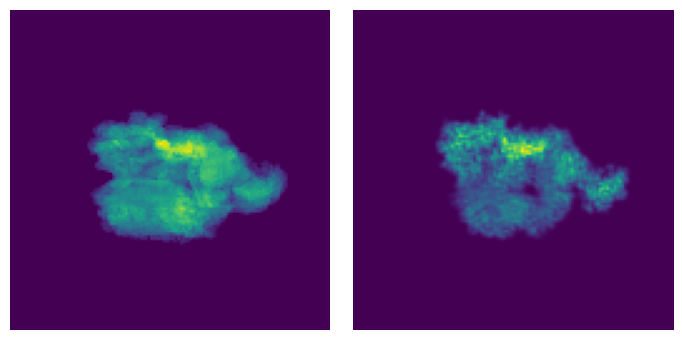

In [7]:
# create projections of the mask
print(f"threshold: {threshold}")
fig, ax = plt.subplots(1,2, figsize=(7, 3.5))
ax[0].imshow(mask_data.sum(axis=0))
ax[1].imshow(vseries_stack[0].sum(axis=0))
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()


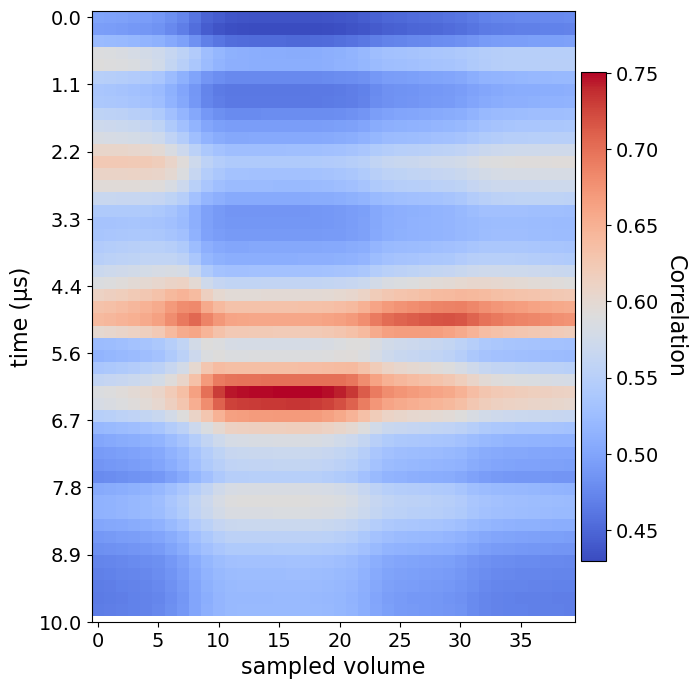

In [9]:
# step 3: plot the correlation matrix
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(correlation_matrix, cmap="coolwarm")
# change the xtick labels for latents
# ax.set_xticks(np.arange(len(volumes)))
# ax.set_xticklabels(
#     [np.round(r, 2) for r in latent_coordinates], rotation=90, fontsize=8)
# set the y-ticklabels to the frames in the pdb_dir
conformation_names = [float(r.split("_")[1].strip(".pdb")) for r in frames]
yticks = np.linspace(0, len(frames), 10)
yticklabels = np.round(np.linspace(0, 10, 10, dtype=float), 1)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel("time (\u03BCs)", fontsize=16)
ax.set_xlabel("sampled volume", fontsize=16)
# ax.set_yticklabels(np.round(np.linspace(0, 10, len(frames)), 2))
# ax.set_yticklabels(conformation_names)
# ax.set_yticklabels([np.round(r*1.2/1000, 1) for r in conformation_names])
# make a colorbar with the same size as the image
cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical", pad=0.01, shrink=0.8)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel("Correlation", fontsize=16, rotation=270, labelpad=20)
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

# fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.png"), dpi=300, bbox_inches="tight")
# fig.savefig(os.path.join(figures_dir, f"{os.path.basename(vseries_dir)}_correlation_matrix.pdf"), bbox_inches="tight")

In [11]:
# save the correlation matrix
np.save(os.path.join(project_dir, "cryosparc_P51_J696_series_000", "correlation_matrix.npy"), correlation_matrix)